In [1]:
from google.oauth2 import service_account
from google.cloud import storage
import tarfile
from zipfile import ZipFile
from zipfile import is_zipfile
import io
import nibabel as nib
import os
import pandas as pd
import tensorflow as tf
import gcsfs
import random
from nilearn import image
import numpy as np

/Users/tobiasbraun/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [32]:
#change path
file_path = '/Users/tobiasbraun/Documents/Studium USA/Columbia University/Semester 3/Deep Learning/Codes/Project/'

In [33]:
api_key = file_path + "deep-learning-255016-4350337ed6f4.json"
credentials = service_account.Credentials.from_service_account_file(api_key)
client = storage.Client(credentials=credentials, project="deep-learning")

In [56]:
fs = gcsfs.GCSFileSystem(token=api_key, project="deep-learning")
with fs.open('mri_data_bucket/ADNI_t1_list_with_fsstatus_20190111.csv') as f:
    df = pd.read_csv(f)

df.to_csv('labels.csv')

In [57]:
bucket_name = "mri_data_bucket"
bucket = client.get_bucket(bucket_name)
prefix = "data"

In [58]:
bucket = client.get_bucket(bucket_name)
blobs = bucket.list_blobs(prefix=prefix)

file_names_list = []
for blob in blobs:
        #print(blob.name)
        file_names_list.append(blob.name)


In [59]:
def _int64_feature(value):
    return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def _float_feature(value):
    return tf.train.Feature(float_list=tf.train.FloatList(value=value))

def _bytes_feature(value):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))


In [60]:
labels=df[['Subject','T1.SERIESID','Group']].copy()

labels=labels[(labels.Group == 'CN')|(labels.Group == 'AD')|(labels.Group == 'EMCI')|(labels.Group == 'LMCI')|(labels.Group == 'MCI')]

labels['new_ind']=labels['Subject']+"_"+labels['T1.SERIESID'].astype(str)
labels.loc[labels.Group == 'CN','Group']=0
labels.loc[labels.Group == 'AD','Group']=1
labels.loc[labels.Group == 'EMCI','Group']=2
labels.loc[labels.Group == 'LMCI','Group']=3
labels.loc[labels.Group == 'MCI','Group']=4
labels = labels.set_index('new_ind')
labels=labels.drop(columns=['Subject','T1.SERIESID'])

labels.shape

(9648, 1)

In [40]:
file_names=file_names_list
#file_names_list
len(file_names_list)

10435

In [41]:
import re
pattern1 = re.compile(r'S\d+')
pattern2 = re.compile(r'\d+_S_\d+')

In [61]:
def download(file_names):
    count=0
    for filename in file_names:
        filename=filename[5:]
        #try:
        series_id = re.search(pattern1, filename).group(0)[1:]
        subject = re.search(pattern2,filename).group(0)
        ind=subject+"_"+series_id

        label=labels.loc[ind,'Group']          
        blob = bucket.blob('data/'+filename)
        print(blob.name)
        blob.download_to_filename(file_path+'data/'+filename)
        count+=1

            #if count % 100 ==0:
             #   print(count)
        #except:
        #    continue
#download(file_names_list)

In [46]:
def normalise(file_names):
    count=0
    
    min_x=np.ones(256**3)*np.inf
    max_x=np.zeros(256**3)
    for filename in file_names:
        filename=filename[5:]
        try:
            image_ = nib.load('data/'+filename)
            image = image_.get_data()
            #=image[:,:,:]#,:,:]#,50:206,50:206]
            x=np.array(image.ravel())
                       
            min_x=np.minimum(min_x,x)           
            max_x=np.maximum(max_x,x)

            count+=1
            if count % 100 ==0:
                print(count)
        except:
            continue
            
    min_ = min_x
    max_ = max_x
    return min_, max_

In [25]:
min_flat, max_flat = normalise(file_names_list)

10435


In [20]:
min_flat.shape

(16777216,)

In [53]:
# for filename in file_names_list[7:10]:
#     filename=filename[5:]
    
#     image_ = nib.load('data/'+filename)
#     print('a')

#     image = image_.get_data()

#     x=image[127,:,:]#[127,50:216,50:216]
#     x=np.array(x.ravel())

#     y=image[:,127,:]#[50:216,127,50:216]
#     y=np.array(y.ravel())

#     z=image[5:,:,127]#[50:216,50:216,127]
#     z=np.array(z.ravel())

#     min_x=np.amin(np.array([min_x,x]), axis=0)
#     min_y=np.amin(np.array([min_y,y]), axis=0)
#     min_z=np.amin(np.array([min_z,z]), axis=0)

#     max_x=np.amax(np.array([max_x,x]), axis=0)
#     max_y=np.amax(np.array([max_y,y]), axis=0)
#     max_z=np.amax(np.array([max_z,z]), axis=0)
#     count+=1

In [54]:
np.save('Normalizing_files/min_flat_3d',min_flat[0])
np.save('Normalizing_files/max_flat_3d',max_flat[0])

FileNotFoundError: [Errno 2] No such file or directory: 'Normalizing_files/min_flat_3d.npy'

In [16]:
min_flat_x = np.load('Normalizing_files/min_flat_3d.npy')
max_flat_x = np.load('Normalizing_files/max_flat_3d.npy')

# min_flat_y = np.load('Normalizing_files/min_flat_y_156.npy')
# max_flat_y = np.load('Normalizing_files/max_flat_y_156.npy')

# min_flat_z = np.load('Normalizing_files/min_flat_z_156.npy')
# max_flat_z = np.load('Normalizing_files/max_flat_z_156.npy')

In [17]:
import re
pattern1 = re.compile(r'S\d+')
pattern2 = re.compile(r'\d+_S_\d+')

In [18]:
file_names=pd.DataFrame()
for filename in file_names_list:
    row=dict()
    row['filename']=filename[5:]
    filename=filename[5:]
    try:
        series_id = re.search(pattern1, filename).group(0)[1:]
        subject = re.search(pattern2,filename).group(0)
        ind=subject+"_"+series_id
        row['ind']=ind
        row['label']=labels.loc[ind,'Group'] 
    except:
        row['ind']= 'No label'
        row['label']= 'No label'   
    file_names=file_names.append(row,ignore_index=True)

file_names = file_names[file_names['ind']!='No label']
file_names[:20]

,filename,ind,label
1,002_S_0295_S110476-T1_T1_brain_mni305.nii,002_S_0295_110476,0
2,002_S_0295_S13408_T1_brain_mni305.nii,002_S_0295_13408,0
3,002_S_0295_S150055-T1_T1_brain_mni305.nii,002_S_0295_150055,0
4,002_S_0295_S21856_T1_brain_mni305.nii,002_S_0295_21856,0
5,002_S_0295_S32678_T1_brain_mni305.nii,002_S_0295_32678,0
6,002_S_0295_S54061_T1_brain_mni305.nii,002_S_0295_54061,0
7,002_S_0295_S67612_T1_brain_mni305.nii,002_S_0295_67612,0
8,002_S_0295_S84944_T1_brain_mni305.nii,002_S_0295_84944,0
10,002_S_0413_S111992-T1_T1_brain_mni305.nii,002_S_0413_111992,0
11,002_S_0413_S13893_T1_brain_mni305.nii,002_S_0413_13893,0


In [19]:
# shuffle table:
file_names = file_names.sample(frac=1)

In [20]:
cut = int(len(file_names)/10)

testing_file_names = file_names[:cut]
validation_file_names = file_names[cut:2*cut]
training_file_names = file_names[2*cut:]

Class 0: 2402
Class 1: 1011
Class 2: 1427
Class 3: 703
Class 4: 2177
Proportion: 2.38 : 1


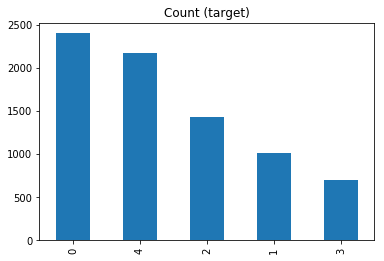

In [21]:
target_count = training_file_names.label.value_counts()
print('Class 0:', target_count[0])
print('Class 1:', target_count[1])
print('Class 2:', target_count[2])
print('Class 3:', target_count[3])
print('Class 4:', target_count[4])
print('Proportion:', round(target_count[0] / target_count[1], 2), ': 1')

target_count.plot(kind='bar', title='Count (target)')

In [22]:
# Class count
count_class_0, count_class_1, count_class_2, count_class_3, count_class_4 = training_file_names.label.value_counts() 

# Divide by class
df_class_0 = training_file_names[training_file_names['label'] == 0]
df_class_1 = training_file_names[training_file_names['label'] == 1]
df_class_2 = training_file_names[training_file_names['label'] == 2]
df_class_3 = training_file_names[training_file_names['label'] == 3]
df_class_4 = training_file_names[training_file_names['label'] == 4]

Random over-sampling:
4    2402
3    2402
2    2402
1    2402
0    2402
Name: label, dtype: int64


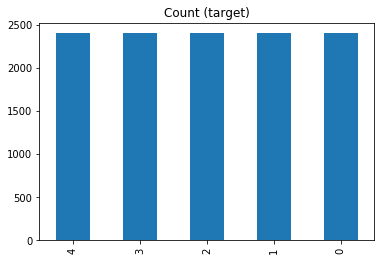

In [23]:
df_class_1_over = df_class_1.sample(count_class_0, replace=True)
df_class_2_over = df_class_2.sample(count_class_0, replace=True)
df_class_3_over = df_class_3.sample(count_class_0, replace=True)
df_class_4_over = df_class_4.sample(count_class_0, replace=True)
training_file_names_over = pd.concat([df_class_0, df_class_1_over, df_class_2_over, df_class_3_over, df_class_4_over], axis=0)

print('Random over-sampling:')
print(training_file_names_over.label.value_counts())
training_file_names_over.label.value_counts().plot(kind='bar', title='Count (target)')

In [24]:
training_file_names_over = training_file_names_over.sample(frac=1).reset_index(drop=True)
training_file_names_over[:10]

,filename,ind,label
0,053_S_0621_S34521_T1_brain_mni305.nii,053_S_0621_34521,4
1,035_S_6551_S717903_T1_brain_mni305.nii,035_S_6551_717903,0
2,033_S_0739_S16956_T1_brain_mni305.nii,033_S_0739_16956,1
3,005_S_0602_S100029_T1_brain_mni305.nii,005_S_0602_100029,0
4,052_S_0951_S79814_T1_brain_mni305.nii,052_S_0951_79814,0
5,116_S_1249_S27350-T1_T1_brain_mni305.nii,116_S_1249_27350,0
6,023_S_0078_S24894_T1_brain_mni305.nii,023_S_0078_24894,4
7,010_S_4345_S214116-T1_T1_brain_mni305.nii,010_S_4345_214116,0
8,127_S_1427_S227972_T1_brain_mni305.nii,127_S_1427_227972,4
9,057_S_1007_S32046_T1_brain_mni305.nii,057_S_1007_32046,4


In [25]:
training_file_names_over.to_csv('training_file_names_over.csv')
testing_file_names.to_csv('testing_file_names.csv')
validation_file_names.to_csv('validation_file_names.csv')

In [26]:
def write_tfrecords(save_filename,file_names,min_,max_):
    i=0
    writer = tf.python_io.TFRecordWriter(save_filename)
    for index, row in file_names.iterrows():
        filename=row['filename']
        label=int(row['label'])
        name=str.encode(row['ind'])
        try:
            image_ = nib.load('data/'+filename)
            im = image_.get_data()
            #im=crop_image[127,50:206,50:206]#,:,:]
            normalized_im=(im.ravel()-min_)/(max_+0.0001-min_)
            feature = {'label': _int64_feature(label),
                   'image': _float_feature(normalized_im),
                     'name': _bytes_feature(name)}
            # Create an example protocol buffer - Protocol buffers are a cross-platform, 
            #    cross-language library for efficient serialization of structured data.
            example = tf.train.Example(features=tf.train.Features(feature=feature))
            # Serialize to string and write on the file
            writer.write(example.SerializeToString())
            i+=1
            if i%50==0:
                print('i: ',i)
        except:
            continue

    writer.close()


In [28]:
training_file_names_over.shape

(12010, 3)

In [ ]:
write_tfrecords('training_flat_256_3d.tfrecords',training_file_names_over,min_flat_x,max_flat_x)
write_tfrecords('testing_flat_256_3d.tfrecords',testing_file_names,min_flat_x,max_flat_x)
write_tfrecords('validation_flat_256_3d.tfrecords',validation_file_names,min_flat_x,max_flat_x)

i:  50
i:  100
i:  200
i:  250
i:  300
i:  350
i:  400
i:  450
i:  500
i:  550
i:  600
i:  650
i:  700
i:  750
i:  800
i:  850
i:  900
i:  950
i:  1000
i:  1050
i:  1100
i:  1150
i:  1200
i:  1250
i:  1300
i:  1350
i:  1600
i:  1650
i:  1700
i:  1750
i:  1800
i:  1850
i:  1900
i:  1950
i:  2000
i:  2050
i:  2100
i:  2150
i:  2200
i:  2250
i:  2300
i:  2500
i:  2550
i:  2600
i:  2650
i:  2700
